In [1]:
!pip install matplotlib opencv-python diffusers transformers scipy accelerate optimum
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

     |████████████████████████████████| 11.2 MB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 61.8 MB 7.8 MB/s eta 0:00:01     |████████                        | 15.4 MB 7.8 MB/s eta 0:00:06
     |████████████████████████████████| 716 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 199 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 190 kB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 757 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 7.6 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 2.3 MB/s eta 0:00:011
     |████████████████████████████████| 6.4 MB 7.7 MB/s eta 0:00:01     |████████████████████████▍       | 4.9 MB 

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 6.4 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 56.8 MB 8.8 MB/s eta 0:00:011    |█████████▊                      | 17.4 MB 7.8 MB/s eta 0:00:06     |███████████████████████████████▍| 55.7 MB 14.1 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 3.2 MB/s eta 0:00:011
     |████████████████████████████████| 490 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 815 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 299 kB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 1.1 MB/s eta 0:00:011
     |████████████████████████████████| 56 kB 2.7 MB/s eta 0:00:011
     |████████████████████████████████| 10.2 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 96 k

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path
from collections import Counter
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
from transformers import pipeline

Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.
/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from preselection import retrieve

I will use a small hardcoded example located in /workspace/dataset23/.
The output directory is /tmp/


In [6]:
from phrase_generation import generate_phrases

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [7]:
def load_queries():
    file_name = 'dataset23/topics.xml'
    
    if not os.path.exists(file_name):
        raise ValueError(f'Could not find the file "{file_name}". Got: {glob(input_directory + "/*")}')
    
    topics = pd.read_xml(file_name)
    
    ret = pd.DataFrame()
    # https://github.com/terrier-org/pyterrier/issues/62\n",
    ret['query'] = topics['title'].apply(lambda i: "".join([x if x.isalnum() else " " for x in i]))
    ret['qid'] = topics['number']
    return ret

In [8]:
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli', accelerator="bettertransformer", device=0)

input_directory = '/workspace/dataset23/'

In [56]:
# load image text
# We use some very baseline method to get a textual representation: we just use the text of the pages that contain the image.
def load_website_text(image_id):
    ret = ''
    for txt_file in glob(input_directory +'/images/' + image_id[:3] + '/' + image_id + '/*/*/*/text.txt'):
        #print(txt_file)
        ret += '\n\n' + open(txt_file).read()
    return ret.strip()

def load_image_text(image_id):
    ret = ''
    for txt_file in glob(input_directory +'/images/' + image_id[:3] + '/' + image_id + '/image-text.txt'):
        #print(txt_file)
        ret += '\n\n' + open(txt_file).read()
    return ret.strip()

def determine_stance(text, query):
    labels = ["contra "+ query, "pro "+ query, "neutral "+ query]
    """print(text)
    print("--------------")
    print(query)
    print(labels)"""
    result = classifier(text, labels)
    # sorts the labels starting with the most likely
    if result["labels"][0].startswith("contra"):
        return "contra", result["scores"][0]
    elif result["labels"][0].startswith("pro"):
        return "pro", result["scores"][0]
    else: 
        return "neutral", result["scores"][0]
    

def detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_ids, query, x, use_website_text=True):
    # get image ids from preranking
    # get image texts based on preranking 
    pro_imgs = {}
    contra_imgs = {}
    pro_ids = []
    contra_ids = []
    
    for image_id in image_ids:
        #print(image_id)
        
        if use_website_text:
            text = load_website_text(image_id)
        else:
            text = load_image_text(image_id)
            
        #print(text)
        #print("----------------")
        
        # image with no text on webpage or on image is sorted out
        if text == "":
            continue
        
        # deploy model
        stance, score = determine_stance(text, query)
        # print(image_id, stance, score)
        # separate pro and con texts; sort out neutral texts
        if stance == "pro":
            pro_imgs[image_id] = score
        elif stance == "contra": 
            contra_imgs[image_id] = score
            
    # sort according to scores
    sorted_pro = dict(sorted(pro_imgs.items(), key=lambda x:x[1], reverse=True))
    sorted_contra = dict(sorted(contra_imgs.items(), key=lambda x:x[1], reverse=True))
    # return best x results for each side
    i = 0
    for key in sorted_pro:
        if i < len(sorted_pro.keys()) and i < x:
            pro_ids.append(key)
        else: 
            break
        i += 1
    i = 0
    for key in sorted_contra:
        if i < len(sorted_contra.keys()) and i < x:
            contra_ids.append(key)
        else: 
            break
        i += 1
        
    return pro_ids, contra_ids, sorted_pro, sorted_contra
# not sorted right

In [10]:
def load_image_paths(image_ids):
    image_paths = []
    
    for image_id in image_ids:
        image_paths.append('dataset23/images/' + image_id[:3] + '/' + image_id + '/image.webp')
        
    return image_paths

In [11]:
def load_image_generator():
    with open('token.txt') as ifp:
        access_token = ifp.readline()
        # print('Read a token of length {}'.format( len(access_token) ))
    
    model_id = "CompVis/stable-diffusion-v1-4"
    device = "cuda"
    
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", use_auth_token=access_token, device_map="auto", cache_dir="stable_diffusion_cache")
    pipe = pipe.to(device)
    
    return pipe
    
def generate_image(pipe, prompt, isrealistic, image_name=None, guidance_scale=20, inference_steps=50):
    if isrealistic:
        final_prompt = "a photograph about the topic: " + prompt
    else:
        final_prompt = "an image in comic style about the topic: " + prompt
    
    print(final_prompt)
    
    image = None
    
    while image == None or not image.getbbox():
        image = pipe(final_prompt, guidance_scale=guidance_scale, num_inference_steps=inference_steps).images[0]
        print(not image.getbbox())

    if image_name != None:
        image.save("image_results/" + image_name + ".png")
    else:
        return image
    
def show_image(image_name):
    image = Image.open("image_results/" + image_name + ".png")
    image.show()

In [12]:
def flann_index_kdtree_matcher(image1, image2):
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1_gray, None)
    kp2, des2 = sift.detectAndCompute(image2_gray, None)
    
    if des1 is None or des2 is None:
        return [], 0
            
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    global good
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    
    if len(good) == 0:
        return [], 0
    
    most_common_keypoint_matches = Counter(x.trainIdx for x in good).most_common(1)[0]
    
    # single keypoint check for to many matches
    if most_common_keypoint_matches[1] > 10:
        return [], 0
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        
        if M is None:
            print("empty Homography on image")
            return [], 0
        
        matchesMask = mask.ravel().tolist()
        
        h,w, _ = image1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        image2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
             
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)
    
    img_matches = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1]+image2.shape[1], 3), dtype=np.uint8)
    # img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, **draw_params)
    
    # plt.imshow(img3, ), plt.show()
    
    return img3, len(good)

In [44]:
def sort_images(images, dataframe):
    sorted_images = []
    
    for i in range(len(images)):
        image_id = dataframe["image_num"][i]
        sorted_images.append(images[image_id])
    
    return sorted_images


def rank_images(images, image_name):
    print("image_results/" + image_name)
    topic_img = cv.cvtColor(cv.imread("image_results/" + image_name), cv.COLOR_BGR2RGB)
    image_ids = []
    match_numbers = []
    img_num = 0

    for image in images:
        # print(img_num)
    
        if image.size <= 100000000:
            img, good_matches = flann_index_kdtree_matcher(topic_img, image.copy())
        
            image_ids.append(img_num)
            match_numbers.append(good_matches)
    
        img_num += 1

    image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframe), sorted_image_id_and_match_num_dataframe


def update_image_id_and_match_num_dataframe(image_id_and_match_num_dataframe, curr_image_id_and_match_num_dataframe):
    for i in range(len(image_id_and_match_num_dataframe)):
        image_id = image_id_and_match_num_dataframe.iloc[i]["image_id"]
        
        for j in range(len(curr_image_id_and_match_num_dataframe)): 
            if image_id == curr_image_id_and_match_num_dataframe.iloc[j]["image_id"]:
                image_id_and_match_num_dataframe.iloc[i]["match_num"] += curr_image_id_and_match_num_dataframe.iloc[j]["match_num"]
        
    return image_id_and_match_num_dataframe


def combined_image_ranking(images, old_image_ids, generated_image_names):
    image_id_and_match_num_dataframe = pd.DataFrame()
    
    for generated_image_name in generated_image_names:
        generated_image = cv.cvtColor(cv.imread("image_results/" + generated_image_name), cv.COLOR_BGR2RGB)
        image_ids = []
        match_numbers = []
        image_numbers = []
        
        for i in range(len(images)):
            if images[i].size <= 100000000:
                img, good_matches = flann_index_kdtree_matcher(generated_image, images[i].copy())
                
                image_numbers.append(i)
                image_ids.append(old_image_ids[i])
                match_numbers.append(good_matches)
        
        if image_id_and_match_num_dataframe.empty:
            image_id_and_match_num_dataframe = pd.DataFrame({"image_num": image_numbers, "image_id": image_ids, "match_num": match_numbers})
        else:
            curr_image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
            image_id_and_match_num_dataframe = update_image_id_and_match_num_dataframe(image_id_and_match_num_dataframe, curr_image_id_and_match_num_dataframe)
    
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframe), sorted_image_id_and_match_num_dataframe
    

In [52]:
def show_multiple_images(image_list, row_count, col_count, save_image_name=None):
    if len(image_list) < row_count:
        row_count = len(image_list)
    
    for i in range(0, len(image_list), row_count*col_count):
        fig = plt.figure(figsize=(20, 20), dpi=80)
    
    for j in range(0, row_count*col_count):
        fig.add_subplot(row_count, col_count, j+1)
        plt.imshow(image_list[i+j])
        
    if save_image_name != None:
        save_path = "image_results/" + save_image_name
        plt.savefig(save_path)
        
    plt.show()

In [46]:
"""def create_submission_format_with_list(preselection_data, image_ids, stance_string, image_num=10):
    submission_format = ""
    rank = 1
    
    for i in range(image_num):
        image_data = preselection_data.loc[preselection_data["docno"] == image_ids[i]]
        
        query_id = image_data["qid"].values[0]
        stance = stance_string
        image_id = image_data["docno"].values[0]
        image_rank = rank
        image_score = 50 - (rank-1)
        method = "-"
        
        submission_format += (str(query_id) + " " + str(stance) + " " + str(image_id) + " " + str(image_rank) + " " + str(image_score) + " " + str(method) + "\n")
        
        rank += 1
        
    print(submission_format)"""

def create_submission_format_with_dataframe(preselection_data, image_id_dataframe, stance_string, max_image_num, show_submission_format):
    submission_format = ""
    rank = 1
    
    if len(image_id_dataframe) < max_image_num:
        image_num = len(image_id_dataframe)
    else:
        image_num = max_image_num
    
    #print(preselection_data['docno'])
    
    for i in range(image_num):
        #print(image_id_dataframe["image_id"][i])
        image_data = preselection_data.loc[preselection_data['docno'] == image_id_dataframe["image_id"][i]]
        #print(image_data)
        
        query_id = image_data["qid"].values[0]
        stance = stance_string
        image_id = image_data["docno"].values[0]
        image_rank = rank
        image_score = image_num - (rank-1)
        method = "-"
        
        submission_format += (str(query_id) + " " + str(stance) + " " + str(image_id) + " " + str(image_rank) + " " + str(image_score) + " " + str(method) + "\n")
        
        rank += 1
        
    if show_submission_format:
        print(submission_format)
    
    return submission_format

In [ ]:
"""def test_full_pipeline(query_with_qid, stance_string, pipe, use_website_text=True, max_image_num=10, show_images=False):
    local_query_with_qid = query_with_qid.copy()
    
    pos_query, con_query = generate_phrases([str(t) for t in local_query_with_qid["query"].values.tolist()], 'frequency')
    
    if stance_string == "pro":
        local_query_with_qid["query"].values[0] = pos_query[0]
    else:
        local_query_with_qid["query"].values[0] = con_query[0]
        
    print(local_query_with_qid["query"].values[0])
    
    preselection_data = retrieve(local_query_with_qid)
    image_docnos = preselection_data["docno"]
    print("preselection")
    #print(image_docnos)
    
    query = local_query_with_qid["query"].values[0]
    
    #pro_ids_web, con_ids_web, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, query, max_image_num, True)
    #pro_ids_image, con_ids_image, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, query, max_image_num, False)
    pro_ids, con_ids, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, query, max_image_num, use_website_text)
    print("stance")
    
    image_ids = []
    if stance_string == "pro":
        image_ids = pro_ids
    else:
        image_ids = con_ids
        
    #print(image_ids)
    
    image_paths = load_image_paths(image_ids)
    #print(image_paths)
    images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]
    print("get images")
    
    if should_gen_new_images:
        generate_image(pipe, query, True, "image_realistic")
        show_image("image_realistic")
        generate_image(pipe, query, False, "image_comic")
        show_image("image_comic")
        print("images generated")
    
    ranked_images, sorted_image_id_and_match_num_dataframe = combined_image_ranking(images, image_ids, ["image_realistic.png", "image_comic.png"])
    print("ranking")
    #print(sorted_image_id_and_match_num_dataframe)

    create_submission_format_with_dataframe(preselection_data, sorted_image_id_and_match_num_dataframe, stance_string)
    print("submission")
    show_multiple_images(ranked_images, (max_image_num//2), 2)
    print("showed images")"""

In [60]:
def pipe_rank_images(image_ids, preselection_data, stance_string, pipe, query, max_image_num, should_gen_new_images, show_images, show_submission_format):
    image_paths = load_image_paths(image_ids)
    images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]
    print("get images")
    
    realistic_image_name = "image_realistic_" + stance_string
    comic_image_name = "image_comic_" + stance_string
    
    if should_gen_new_images:
        generate_image(pipe, query, True, realistic_image_name)
        show_image(realistic_image_name)
        generate_image(pipe, query, False, comic_image_name)
        show_image(comic_image_name)
        print("images generated")
    
    realistic_image_name += ".png"
    comic_image_name += ".png"
    ranked_images, sorted_image_id_and_match_num_dataframe = combined_image_ranking(images, image_ids, [realistic_image_name, comic_image_name])
    print("ranking")

    submission_format = create_submission_format_with_dataframe(preselection_data, sorted_image_id_and_match_num_dataframe, stance_string, max_image_num, show_submission_format)
    print("submission")
    
    if show_images:
        show_multiple_images(ranked_images, (max_image_num), 1)
        print("showed images")
    
    return submission_format
    

def full_pipeline(query_with_qid, stance_string, pipe, max_image_num=10, should_gen_new_images=True, show_images=False, show_submission_format=True):
    local_query_with_qid = query_with_qid.copy()
    
    print(local_query_with_qid["query"].values[0])
    
    pos_query, con_query = generate_phrases([str(t) for t in local_query_with_qid["query"].values.tolist()], 'frequency')
    
    local_query_with_qid["query"].values[0] = pos_query[0]
    preselection_data_pro = retrieve(local_query_with_qid)
    image_docnos_pro = preselection_data_pro["docno"]
    
    local_query_with_qid["query"].values[0] = con_query[0]
    preselection_data_con = retrieve(local_query_with_qid)
    image_docnos_con = preselection_data_con["docno"]
    print("preselection")
    #print(preselection_data)
    
    submission_pipe1_pro = pipe_rank_images(image_docnos_pro, preselection_data_pro, "pro", pipe, pos_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
    submission_pipe1_con = pipe_rank_images(image_docnos_con, preselection_data_con, "con", pipe, con_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
    
    pro_ids_web, _, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_pro, pos_query[0], max_image_num, True)
    _, con_ids_web, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_con, con_query[0], max_image_num, True)
    
    submission_pipe2_pro = pipe_rank_images(pro_ids_web, preselection_data_pro, "pro", pipe, pos_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
    submission_pipe2_con = pipe_rank_images(con_ids_web, preselection_data_con, "con", pipe, con_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
    
    pro_ids_image, _, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_pro, pos_query[0], max_image_num, False)
    _, con_ids_image, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_con, con_query[0], max_image_num, False)
    
    submission_pipe3_pro = pipe_rank_images(pro_ids_image, preselection_data_pro, "pro", pipe, pos_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
    submission_pipe3_con = pipe_rank_images(con_ids_image, preselection_data_con, "con", pipe, con_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
    
    # combine stance from web and image
    #submission_pipe4_pro =
    #submission_pipe4_con =
    
    return submission_pipe1_pro, submission_pipe1_con, submission_pipe2_pro, submission_pipe3_pro, submission_pipe3_con

In [18]:
diff_pipe = load_image_generator()

Fetching 16 files: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 250.59it/s]
/opt/conda/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,


In [19]:
queries = load_queries()
# pos_queries, con_queries = generate_phrases([str(t) for t in queries["query"].values.tolist()], 'frequency')
query_num = 1

selected_query_with_qid = queries.iloc[[query_num]]
# selected_query_with_qid["query"].values[0] = pos_queries[query_num]
selected_query_with_qid

query  qid
1  Should stem cell research be expanded    52

In [ ]:
test_full_pipeline(selected_query_with_qid, "pro", diff_pipe, True, 10, True)

Should stem cell research be expanded 


BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19q/s]


preselection
get images
ranking
submission


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

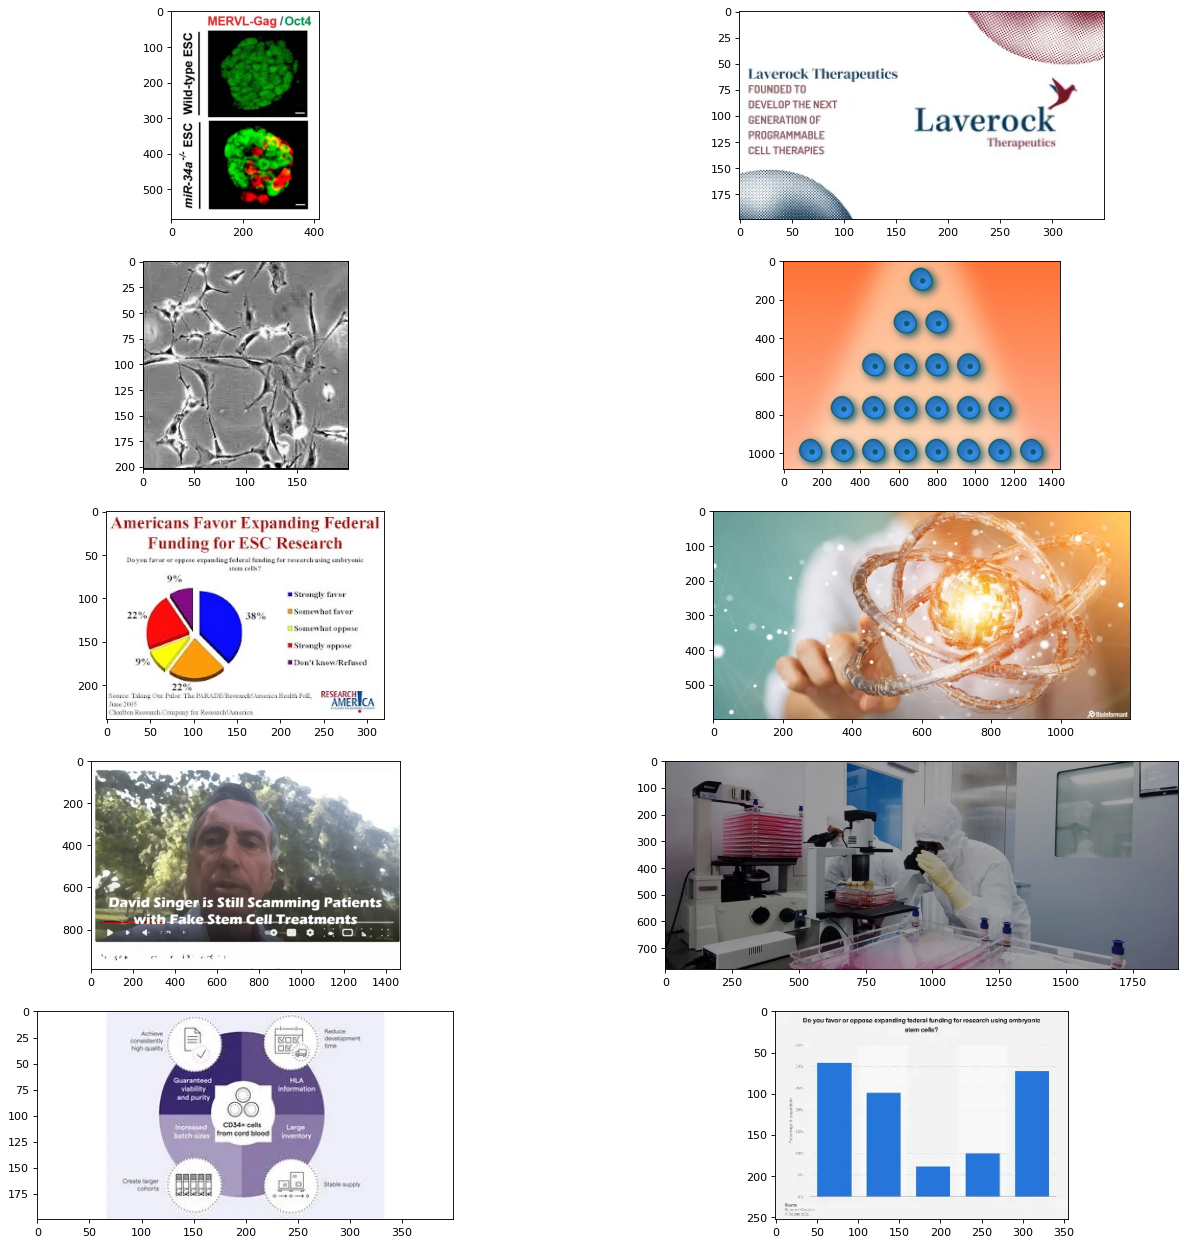

showed images
get images
empty Homography on image
ranking
submission


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

showed images
['I21c99e0c5063a8dc371d59fb', 'Ifaa868f4f7c777540e9ac0fc', 'If67600b6dcf3d1a2bedf9e3f', 'Ib9b55657fd05b1468ddb4256', 'I7decac86f4d533bc71fa28ef', 'I42cf961ed76cdfd506018d95', 'I743265cc02858cf5aaa24c58', 'I95af2379b3e69cca83deadcf', 'Ieb5b29459152a08ca1e71cde', 'Ibf97667a876cdf3843f98152']
{'I21c99e0c5063a8dc371d59fb': 0.5697311758995056, 'Ifaa868f4f7c777540e9ac0fc': 0.46064233779907227, 'If67600b6dcf3d1a2bedf9e3f': 0.45428526401519775, 'Ib9b55657fd05b1468ddb4256': 0.44816792011260986, 'I7decac86f4d533bc71fa28ef': 0.43097996711730957, 'I42cf961ed76cdfd506018d95': 0.42430585622787476, 'I743265cc02858cf5aaa24c58': 0.42077308893203735, 'I95af2379b3e69cca83deadcf': 0.42077308893203735, 'Ieb5b29459152a08ca1e71cde': 0.4199711084365845, 'Ibf97667a876cdf3843f98152': 0.4146682322025299, 'Icbc63dd20f9252782d98ab20': 0.4136446416378021, 'If8bcc9bf6a7f4231c3fc48f4': 0.4136446416378021, 'Iffb3685f25b6ce45e956be9f': 0.4131346344947815, 'I392d100c974cc16865643b9e': 0.4007132351398468, '

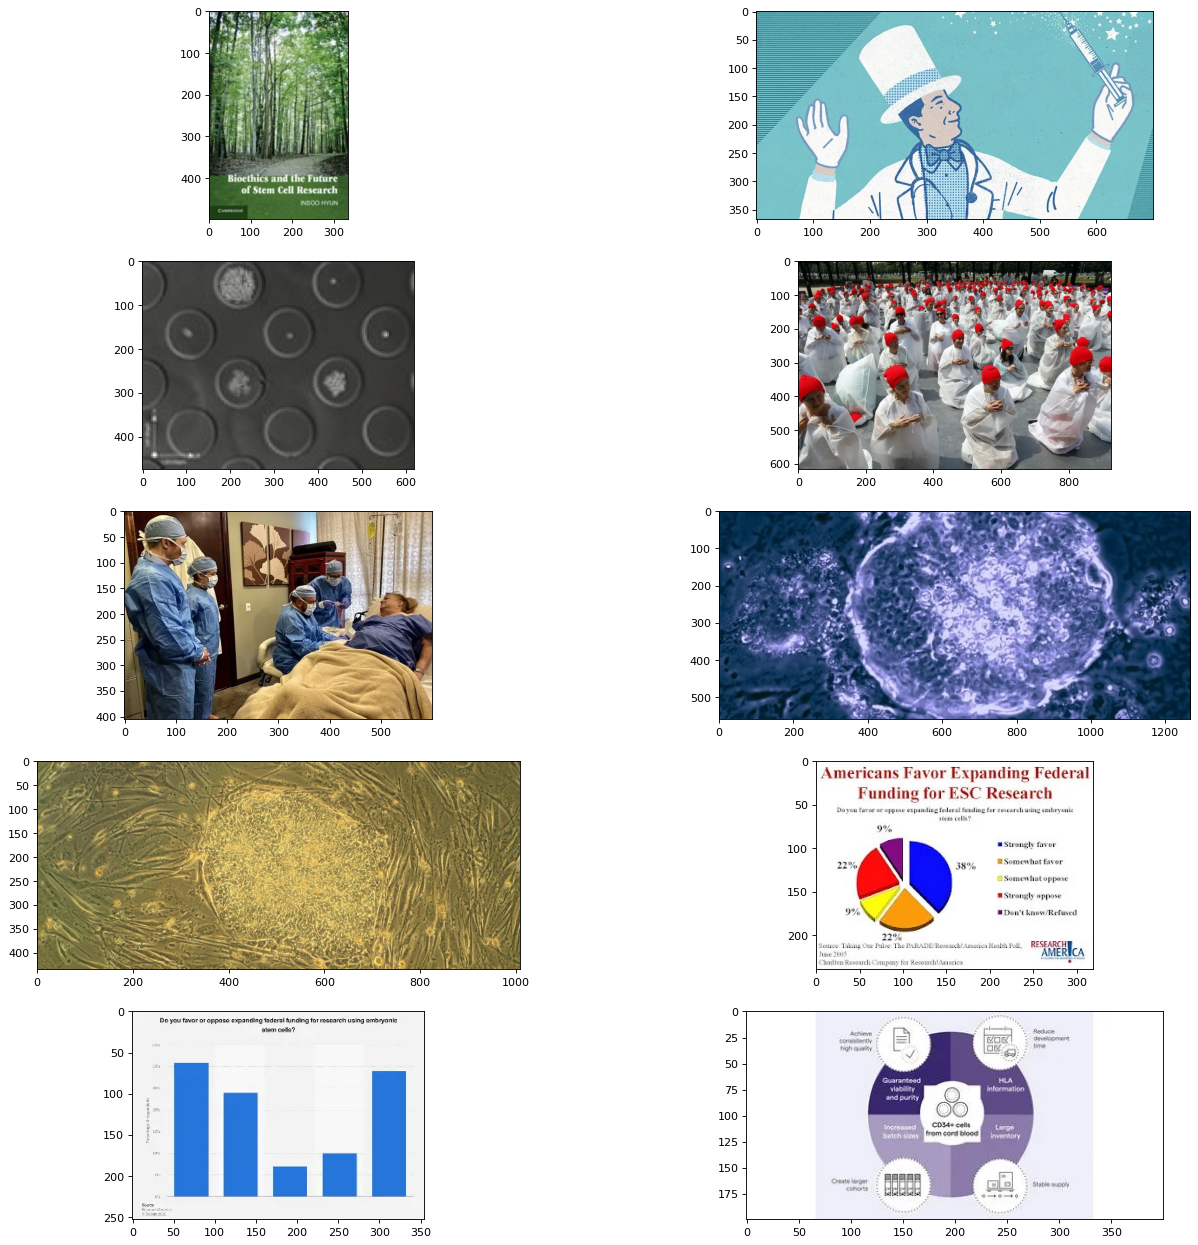

showed images
get images
ranking
submission


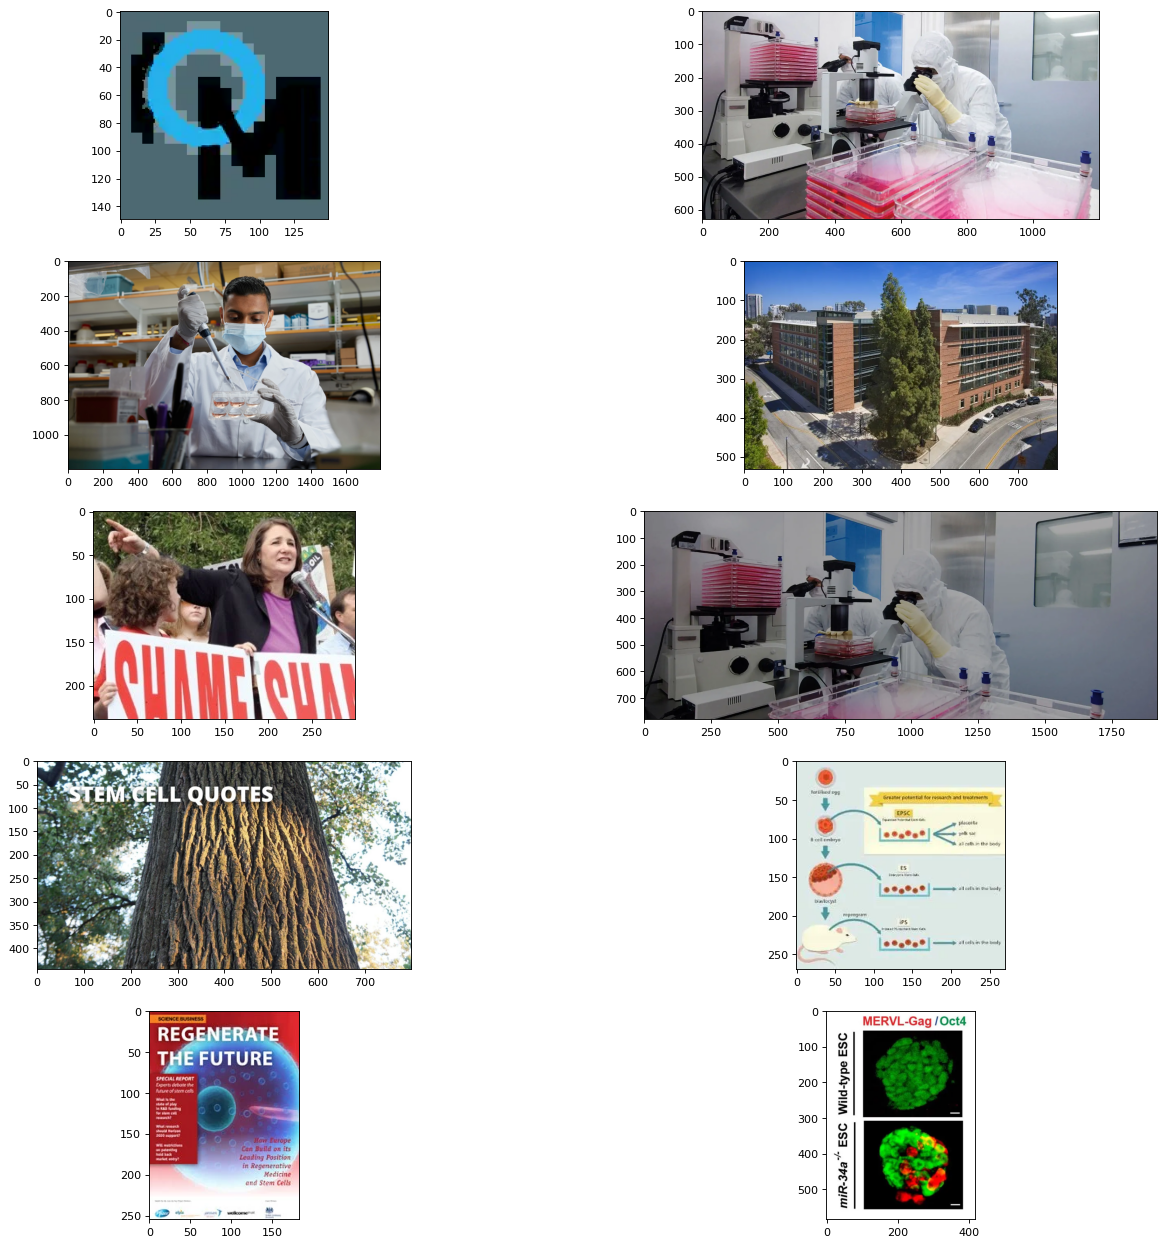

showed images
['I21c99e0c5063a8dc371d59fb', 'I5fd2fcb492a6c3d30f8ae063', 'I5b715040d20e3e0dba8da1a9', 'Icbc63dd20f9252782d98ab20', 'I42cf961ed76cdfd506018d95', 'Iffb3685f25b6ce45e956be9f', 'I7f1a4570e8814fc914734c28']
{'I21c99e0c5063a8dc371d59fb': 0.6714195609092712, 'I5fd2fcb492a6c3d30f8ae063': 0.5935590267181396, 'I5b715040d20e3e0dba8da1a9': 0.4531289041042328, 'Icbc63dd20f9252782d98ab20': 0.44863685965538025, 'I42cf961ed76cdfd506018d95': 0.4450940787792206, 'Iffb3685f25b6ce45e956be9f': 0.40581557154655457, 'I7f1a4570e8814fc914734c28': 0.3845473825931549}
['I21c99e0c5063a8dc371d59fb']
{'I21c99e0c5063a8dc371d59fb': 0.6125034093856812}
get images
ranking
submission


IndexError: list index out of range

In [55]:
full_pipeline(selected_query_with_qid, "pro", diff_pipe, 10, False, True, False)

In [127]:
preselection_data = retrieve(selected_query_with_qid)

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.76q/s]


In [128]:
preselection_data

qid  docid                      docno  rank      score  \
0   52  20784  I5fd2fcb492a6c3d30f8ae063     0  19.460122   
1   52  40375  Ib9b55657fd05b1468ddb4256     1  19.318157   
2   52  50325  Ie75cfd0e47f6164a6ecc69f5     2  19.299695   
3   52  19772  I5b715040d20e3e0dba8da1a9     3  19.294890   
4   52  33299  I98eaa3b9e7ef3241939b5f38     4  19.230826   
5   52  14451  I42cf961ed76cdfd506018d95     5  19.203077   
6   52  40947  Ibc4ca078160688d6233e163c     6  19.191474   
7   52  24896  I728a5165903a65c8146d337b     7  19.179710   
8   52  36738  Ia8ba914f70927f90de3fc1fc     8  19.146130   
9   52  37339  Iab7e77309b66845590fd1b2d     9  19.105647   
10  52   5975  I1b9591967553ed2fd074602d    10  19.079916   
11  52  27389  I7decac86f4d533bc71fa28ef    11  19.071075   
12  52  54508  Ifa543eb4c61640af5d84a2b6    12  19.063453   
13  52   4133  I13391a2fbd72f9a881ab204a    13  19.033594   
14  52   6347  I1d60513c028176df29970a15    14  19.033594   
15  52  41748  Ibff972ea43686ab784e1d426    15  19.016664   
16  52  27651  I7f1a4570e8814fc914734c28    16  18.953899   
17  52  25711  I765d2e00dbbfde1bf3ab31ab    17  18.863520   
18  52   5921  I1b5d9d639a28fcecf6d836b2    18  18.796590   
19  52  24909  I729b1556bce74b5506be7c01    19  18.782842   
20  52  27333  I7da7c6133080644c364e65f3    20  18.781278   
21  52  54949  Ifc744d75f3614697ccf00ef5    21  18.775266   
22  52  23595  I6ccb76ee23116c9104cd608c    22  18.749854   
23  52  49105  Ie1ccfb2eae9434a2c00393c7    23  18.719233   
24  52  55632  Iffb3685f25b6ce45e956be9f    24  18.711221   
25  52  33882  I9bb564e1a30d34ca1f9d9950    25  18.710740   
26  52  49562  Ie3ecd19c2831fa4ad273c8e6    26  18.710740   
27  52  44357  Icbc63dd20f9252782d98ab20    27  18.679726   
28  52  54148  If8bcc9bf6a7f4231c3fc48f4    28  18.679726   
29  52  14369  I4275c61efe96d918ae2e3f5f    29  18.676140   
30  52  27719  I7f7a8dde496aa6a48f3876d4    30  18.676140   
31  52  49546  Ie3df41eb745586a8adc1225f    31  18.660703   
32  52  18179  I5467edd5587d8532e1279b02    32  18.609184   
33  52  42580  Ic3b525c885bab0ec943e1a71    33  18.583753   
34  52  12379  I392d100c974cc16865643b9e    34  18.550141   
35  52  35258  Ia2373604fed94fd87a85ca3c    35  18.542965   
36  52   7327  I21c99e0c5063a8dc371d59fb    36  18.496037   
37  52  51190  Ieb5b29459152a08ca1e71cde    37  18.492970   
38  52  48160  Idd79d719b7f3500bef2784c3    38  18.484704   
39  52  36551  Ia7ec5fbc8a8e2b19bf2c404c    39  18.462194   
40  52  53627  If67600b6dcf3d1a2bedf9e3f    40  18.424649   
41  52  41672  Ibf97667a876cdf3843f98152    41  18.403859   
42  52  35902  Ia50f5ac9e170ce7900693686    42  18.382491   
43  52  33528  I9a01c820de0d93dedafb09c6    43  18.378496   
44  52  47335  Id9d011b26ba1e2eb69f538b5    44  18.378496   
45  52  18593  I5623e49bf61854f09255d642    45  18.366653   
46  52  36807  Ia90f87e034c30b41e9028f1c    46  18.366653   
47  52  25243  I743265cc02858cf5aaa24c58    47  18.358338   
48  52  32611  I95af2379b3e69cca83deadcf    48  18.358338   
49  52  54572  Ifaa868f4f7c777540e9ac0fc    49  18.347054   

                                     query  
0   Should stem cell research be expanded   
1   Should stem cell research be expanded   
2   Should stem cell research be expanded   
3   Should stem cell research be expanded   
4   Should stem cell research be expanded   
5   Should stem cell research be expanded   
6   Should stem cell research be expanded   
7   Should stem cell research be expanded   
8   Should stem cell research be expanded   
9   Should stem cell research be expanded   
10  Should stem cell research be expanded   
11  Should stem cell research be expanded   
12  Should stem cell research be expanded   
13  Should stem cell research be expanded   
14  Should stem cell research be expanded   
15  Should stem cell research be expanded   
16  Should stem cell research be expanded   
17  Should stem cell research be expanded   
18  Should stem cell research be exp

In [137]:
test = preselection_data.loc[preselection_data['docno'] == "I5fd2fcb492a6c3d30f8ae063"]

In [140]:
test["qid"]

0    52
Name: qid, dtype: object

In [19]:
def load_website_text(image_id):
    ret = ''
    for txt_file in glob(input_directory +'/images/' + image_id[:3] + '/' + image_id + '/*/*/*/text.txt'):
        print(txt_file)
        ret += '\n\n' + open(txt_file).read()
    return ret.strip()

image_id = "I5fd2fcb492a6c3d30f"

text = glob(input_directory +'/images/' + image_id[:3] + '/' + image_id + '/*/*/*/text.txt')
for i in text:
    print(i)
    
load_website_text(image_id)

''

In [ ]:
local_query_with_qid = selected_query_with_qid.copy()
stance_string = "pro"
max_image_num = 10
    
if stance_string == "pro":
    local_query_with_qid["query"].values[0] += " good"
else:
    local_query_with_qid["query"].values[0] += " bad"

preselection_data = retrieve(local_query_with_qid)
image_docnos = preselection_data["docno"]
print("preselection")

query = local_query_with_qid["query"].values[0]

pro_ids, con_ids, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, query, max_image_num)
print("stance")

image_ids = []
if stance_string == "pro":
    image_ids = pro_ids
else:
    image_ids = con_ids

image_paths = load_image_paths(image_ids)
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]
print("get images")

ranked_images, sorted_image_id_and_match_num_dataframe = combined_image_ranking(images, ["image_realistic.png", "image_comic.png"])

In [ ]:
image_ids

In [ ]:
test = sorted_image_id_and_match_num_dataframe["image_id"].values

In [ ]:
preselection_data

In [ ]:
pos_queries, con_queries = generate_phrases([str(t) for t in queries.iloc[[0]]["query"].values.tolist()], 'frequency')

pos_queries

In [ ]:
preselection_data.loc[preselection_data["docno"] == image_ids[0]]["qid"].values[0]